In [23]:
#!apt-get -y install openjdk-8-jre-headless
#!pip install pyspark

## 建立Spark物件

In [24]:
#from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, rand, split, create_map
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator 
from itertools import chain
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
#drive.mount('/content/gdrive')

In [25]:
spark = SparkSession.builder.appName("final").getOrCreate()

In [26]:
train = spark.read.parquet("train",header = True)
test = spark.read.parquet("test",header = True)

### 計算訓練集分類權重

In [27]:
import numpy as np
y_collect = train.select("事故類別名稱_numeric").groupBy("事故類別名稱_numeric").count().collect()
unique_y = [x["事故類別名稱_numeric"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]

class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark)


{0.0: 0.5024682249470879, 1.0: 101.78736454712738}


In [28]:
mapping_expr = create_map([lit(x) for x in chain(*class_weights_spark.items())])
train = train.withColumn("weight", mapping_expr.getItem(col("事故類別名稱_numeric")))

/Users/shishihh/anaconda3/lib/python3.10/site-packages/pyspark/sql/column.py:322: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


In [29]:
train.show(10)

+--------+--------+--------------+--------------------+--------------------+----------------+----------------+-------------------------------+--------------------------+--------------------------+-----------------------------+-----------------------------+-----------------------------+---------------------------+-----------------------------+-------------------------+-------------------------+---------------------------------------+----------------------------------------------------+--------------------------------------------+------------------------------------------+--------------------------------+--------------------------------+-------------------------------+-------------------------------+---------------------------------------+---------------------------------------+--------------+------------+--------------------+--------------------------------------------+--------------------------------+-----------------------------------+-----------------------------------+--------------

## Model training

### 自定義cross validation 模型

In [30]:
class CrossValidatorVerbose(CrossValidator):
    def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        eva = self.getOrDefault(self.evaluator)
        nFolds = self.getOrDefault(self.numFolds)
        seed = self.getOrDefault(self.seed)
        h = 1.0 / nFolds

        randCol = self.uid + "_rand"
        df = dataset.select("*", rand(seed).alias(randCol))
        f1_val = []
        f1_train = []

        for i in range(nFolds):
            foldNum = i + 1
            validateLB = i * h
            validateUB = (i + 1) * h
            condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
            validation = df.filter(condition)
            train = df.filter(~condition)
            model = est.fit(train)
            prediction_val = model.transform(validation)
            prediction_train = model.transform(train)
            metric_val = (eva[0].evaluate(prediction_val)+eva[1].evaluate(prediction_val))*0.5
            f1_val.append(metric_val)
            metric_train = (eva[0].evaluate(prediction_train)+eva[1].evaluate(prediction_train))*0.5
            f1_train.append(metric_train)
            print(f"Fold {foldNum}  | F1-score | Validation: {metric_val} | Train: {metric_train}")
        
        Allmodel = est.fit(dataset)        
        avgMetrics = sum(f1_val)/len(f1_val)
        print(f"Average | F1-score | Validation: {avgMetrics} | Train: {sum(f1_train)/len(f1_train)}")

        return self._copyValues(CrossValidatorModel(Allmodel, avgMetrics))
# Reference: https://stackoverflow.com/questions/53600615/cross-validation-metrics-with-pyspark

In [31]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = '事故類別名稱_numeric',
                subsamplingRate = 0.8, featureSubsetStrategy = "sqrt", numTrees = 15, maxDepth = 11, weightCol="weight")
#grid = ParamGridBuilder().build()

#Create ParamGrid for Cross Validation
grid = ParamGridBuilder().build()
#               .addGrid(rf.maxDepth, [9,10,12])\
#               .addGrid(rf.maxBins, [10,20,32])\
#               .addGrid(rf.numTrees, [5,10,15])\

evaluator_0 = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', metricLabel = 0.0, beta=1.0, labelCol = '事故類別名稱_numeric')
evaluator_1 = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', metricLabel = 1.0, beta=1.0, labelCol = '事故類別名稱_numeric')

In [32]:
# random forest model
# model = rf.fit(train)
# prediction_train = model.transform(train)
# prediction_test = model.transform(test)
# metric_train = (evaluator_0.evaluate(prediction_train) + evaluator_1.evaluate(prediction_train))*0.5
# metric_test = (evaluator_0.evaluate(prediction_test) + evaluator_1.evaluate(prediction_test))*0.5
# print(f"F1-score | Train: {metric_train} | Test: {metric_test}")

In [33]:
cv = CrossValidatorVerbose(estimator=rf, estimatorParamMaps=grid, evaluator=[evaluator_0,evaluator_1], seed = 20230515, numFolds=5)

In [34]:
cvModel = cv.fit(train)

23/05/29 15:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1091.0 KiB
23/05/29 15:24:06 WARN DAGScheduler: Broadcasting large task binary with size 1596.0 KiB
23/05/29 15:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1213.3 KiB
23/05/29 15:24:14 WARN DAGScheduler: Broadcasting large task binary with size 1213.3 KiB
23/05/29 15:24:17 WARN DAGScheduler: Broadcasting large task binary with size 1213.3 KiB
23/05/29 15:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1213.3 KiB


Fold 1  | F1-score | Validation: 0.5042680328874842 | Train: 0.5158900167824606


23/05/29 15:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.8 KiB
23/05/29 15:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1567.8 KiB
23/05/29 15:24:54 WARN DAGScheduler: Broadcasting large task binary with size 1186.1 KiB
23/05/29 15:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1186.1 KiB
23/05/29 15:24:58 WARN DAGScheduler: Broadcasting large task binary with size 1186.1 KiB
23/05/29 15:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1186.1 KiB


Fold 2  | F1-score | Validation: 0.507650121950354 | Train: 0.5169394292768695


23/05/29 15:25:29 WARN DAGScheduler: Broadcasting large task binary with size 1101.2 KiB
23/05/29 15:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1616.1 KiB
23/05/29 15:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1221.8 KiB
23/05/29 15:25:39 WARN DAGScheduler: Broadcasting large task binary with size 1221.8 KiB
23/05/29 15:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1221.9 KiB
23/05/29 15:25:45 WARN DAGScheduler: Broadcasting large task binary with size 1221.9 KiB


Fold 3  | F1-score | Validation: 0.5071086756656406 | Train: 0.516620971174131


23/05/29 15:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1082.4 KiB
23/05/29 15:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1586.0 KiB
23/05/29 15:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1198.0 KiB
23/05/29 15:26:17 WARN DAGScheduler: Broadcasting large task binary with size 1198.0 KiB
23/05/29 15:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1198.0 KiB
23/05/29 15:26:23 WARN DAGScheduler: Broadcasting large task binary with size 1198.0 KiB


Fold 4  | F1-score | Validation: 0.5086842986732372 | Train: 0.5180019614181086


23/05/29 15:26:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.5 KiB
23/05/29 15:26:57 WARN DAGScheduler: Broadcasting large task binary with size 1564.2 KiB
23/05/29 15:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1186.4 KiB
23/05/29 15:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1186.4 KiB
23/05/29 15:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1186.4 KiB
23/05/29 15:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1186.4 KiB


Fold 5  | F1-score | Validation: 0.5125369813303504 | Train: 0.5248944084896329


23/05/29 15:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1153.2 KiB
23/05/29 15:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1721.6 KiB


Average | F1-score | Validation: 0.5080496221014131 | Train: 0.5184693574282406


### 儲存模型

In [35]:
model_path = "cv_model_train_weight_8"
cvModel.bestModel.save(model_path)

## Evaluate

### load model

In [36]:
model = RandomForestClassificationModel.load(model_path)

### Prediction

In [37]:
prediction_test = model.transform(test)
auroc_evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderROC',labelCol = '事故類別名稱_numeric')
test_auroc = auroc_evaluator.evaluate(prediction_test)
metric_test = (evaluator_0.evaluate(prediction_test) + evaluator_1.evaluate(prediction_test))*0.5

23/05/29 15:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
23/05/29 15:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1339.3 KiB
23/05/29 15:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1339.3 KiB


In [38]:
print(f"F1-Score | Test: {metric_test}")
print(f"AUROC    | Test: {test_auroc}")

F1-Score | Test: 0.5059108243135163
AUROC    | Test: 0.8398085699393409


In [39]:
y_true = prediction_test.select(['事故類別名稱_numeric']).collect()
y_pred = prediction_test.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

23/05/29 15:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1325.2 KiB


              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95    424636
         1.0       0.03      0.56      0.06      2100

    accuracy                           0.91    426736
   macro avg       0.51      0.74      0.51    426736
weighted avg       0.99      0.91      0.95    426736



### Confusion matrix

Text(0.5, 1.0, 'Testing set')

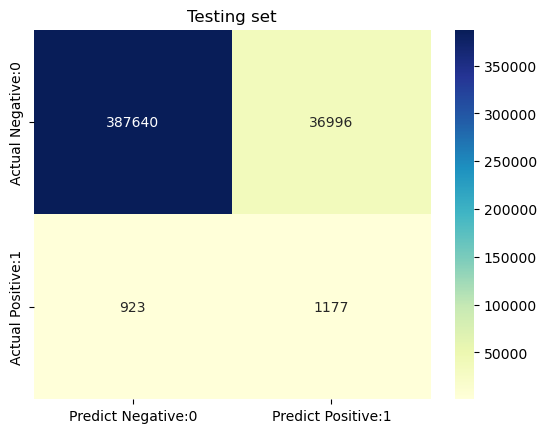

In [40]:
cm = confusion_matrix(y_true,y_pred)
cm_matrix_1 = pd.DataFrame(data=cm, index=['Actual Negative:0', 'Actual Positive:1'], columns=['Predict Negative:0','Predict Positive:1'])
ax = sns.heatmap(cm_matrix_1, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title("Testing set")

### Feature importance

In [41]:
features = ['發生日期', '發生時間', '速限-第1當事者', '當事者事故發生時年齡', '天候名稱_numeric', '光線名稱_numeric', '道路類別-第1當事者-名稱_numeric', '道路型態子類別名稱_numeric', '事故位置子類別名稱_numeric', '路面狀況-路面鋪裝名稱_numeric', '路面狀況-路面狀態名稱_numeric', '路面狀況-路面缺陷名稱_numeric', '道路障礙-障礙物名稱_numeric', '道路障礙-視距品質名稱_numeric', '號誌-號誌種類名稱_numeric', '號誌-號誌動作名稱_numeric', '車道劃分設施-分向設施大類別名稱_numeric', '車道劃分設施-分道設施-快車道或一般車道間名稱_numeric', '車道劃分設施-分道設施-快慢車道間名稱_numeric', '車道劃分設施-分道設施-路面邊線名稱_numeric', '事故類型及型態大類別名稱_numeric', '事故類型及型態子類別名稱_numeric', '肇因研判大類別名稱-主要_numeric', '肇因研判子類別名稱-主要_numeric', '當事者區分-類別-大類別名稱-車種_numeric', '當事者區分-類別-子類別名稱-車種_numeric', '無或物_numeric', '性別_numeric', '保護裝備名稱_numeric', '行動電話或電腦或其他相類功能裝置名稱_numeric', '當事者行動狀態子類別名稱_numeric', '車輛撞擊部位大類別名稱-最初_numeric', '車輛撞擊部位子類別名稱-最初_numeric', '肇事逃逸類別名稱-是否肇逃_numeric', 'site_id_numeric', 'holiday_numeric']

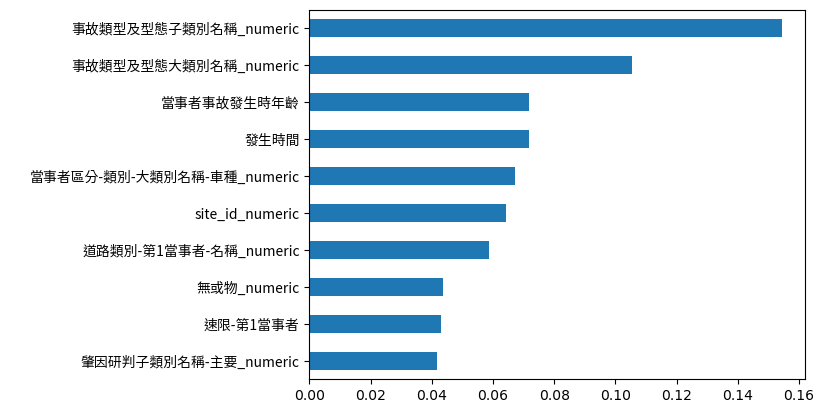

In [42]:
from matplotlib.font_manager import FontProperties as font
import matplotlib.pyplot as plt
font1 = font(fname="Noto_Sans_TC/NotoSansTC-Regular.otf")
featureImportances = model.featureImportances.toArray()
f = {"index":features, "FI" : featureImportances}
FI = pd.DataFrame(f)
FI = FI.set_index('index')
FI_10 = FI.nlargest(10,'FI').iloc[::-1]
axes = FI_10.plot(kind='barh',legend=None)
plt.ylabel(' ',fontproperties=font1)
for label in axes.get_yticklabels():
    label.set_fontproperties(font1)

In [43]:
spark.stop()

In [44]:
# https://towardsdatascience.com/machine-learning-on-a-large-scale-2eef3bb749ee